## Surfaces for plots

* Surfaces to .db files for plotting

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

In [3]:
surface_stochiometry = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)

Make HEA surface for plotting

In [5]:
from ase.build import fcc111
from ase.db import connect

atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)
symbols = np.random.choice(metals, size = 20*20*3)
atoms.set_chemical_symbols(symbols)

db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "HEA.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

In [6]:
symbols

array(['Pt', 'Pd', 'Ag', ..., 'Pd', 'Cu', 'Pd'], dtype='<U2')

Make SWR surface for plotting

In [7]:
dim_x, dim_y, dim_z = 20, 20, 3
SWR_surface = initialize_swim_surface(["Pt"], ["Au"], dim_x, dim_y)
symbols = SWR_surface["atoms"].flatten()

In [9]:
from ase.build import fcc111
from ase.db import connect

atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)

SWR_surface = initialize_swim_surface(["Pt"], ["Au"], dim_x, dim_y)
symbols = SWR_surface["atoms"].flatten()
atoms.set_chemical_symbols(symbols)

db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "SWR.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

Doesn't look like a proper swim ring surface, find the place where I already did that - I didn't, I just made it for plotting

Making a forced optimal top layer and the same 1/3 underneath

In [48]:
def generate_top_layer(dim_x, dim_y):
    pattern = ["Pt", "Au", "Au"]
    top_layer = []

    for i in range(dim_y):
        row = []

        # Calculate the starting index for this row
        start_index = (i * 2) % len(pattern)

        # Create the row with the repeating pattern
        for j in range(dim_x):
            row.append(pattern[(start_index + j) % len(pattern)])

        top_layer.append(row)

    return top_layer

In [49]:
# This works for making the .db file for the plot!

from ase.build import fcc111
from ase.db import connect

# Create the atoms object
atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)

# Make the bottom two layers with the 1/3 frac
third_surface = create_surface(dim_x, dim_y, ["Pt", "Au"], [0.33, 0.67])
third_surface = third_surface.reshape(3, 20, 20)

# Generate the optimal swim ring top layer
top_layer_SWR = generate_top_layer(dim_x, dim_y)

# Switch out the top layer with the swim ring layer
third_surface[2,:,:] = top_layer_SWR

# Flatten the whole surface to get the symbols
symbols = third_surface.flatten()
symbols = symbols.reshape(3, 20, 20)
symbols = symbols.flatten()

# Set the symbols om the atoms object
atoms.set_chemical_symbols(symbols)

# Save the atoms object
db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "SWR2.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

Soo my learnings are:

Ase thinks the shape is 3, 20, 20 instead of 20, 20, 3.
The code above makes swim rings that look good in ase

When I want to make swim rings that work when making feature vectors and predict energies I have to make the swim ring top layer in another way which looks right when i slice like this: 
surface["atoms"][:,:,0]

I'm not sure what I should do to optimize that hard set structure. Maybe input all five metals and stoichiometries as normal, but put Pd and Pt in the middle and Cu, Au, Ag in swim rings.

Anyways, now I have for my plot and then I'll keep on looking at the code that makes surfaces

## Now I'll use the *COOH model on an even HEA surface

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

#### Create 200 by 200 HEA surface

In [30]:
# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 200, 200, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

HEA_surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
HEA_surface = precompute_binding_energies_SPEED(HEA_surface, dim_x, dim_y, models)

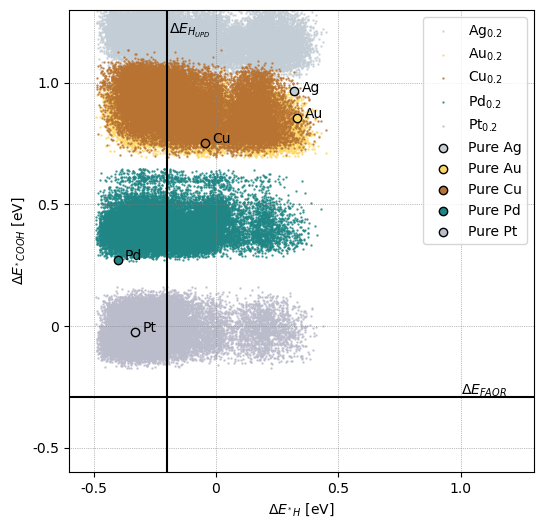

In [31]:
experiment_name = "Binding_Energy_Predictions/H_COOH_HEA_EVEN"
reward_type = "None"
title_text = "Predicted energies for $^*COOH$ and $^*H$ for whole surface"
title_text = ""

deltaEdeltaE_plot(experiment_name, HEA_surface, title_text, pure_metal_info, reward_type, True)

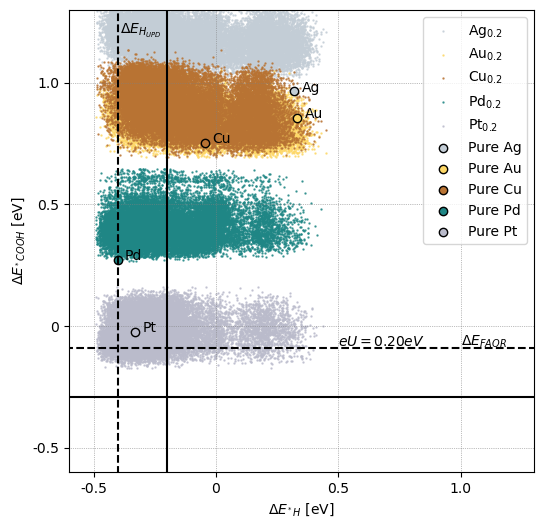

In [48]:
# Lines that move with the deltaG=0 when potential (eU) changes
experiment_name = "Binding_Energy_Predictions/H_COOH_HEA_EVEN_eU020"
reward_type = "None"
title_text = "Predicted energies for $^*COOH$ and $^*H$ for whole surface"
title_text = ""
potential = +0.20 # eU term
deltaEdeltaE_plot_potential(experiment_name, HEA_surface, potential, title_text, pure_metal_info, reward_type, True)

In [22]:
number_matrix = HEA_surface["COOH_E"]
label_matrix  = HEA_surface["atoms"][:,:,0]

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix)

# Initialize a dictionary to store separated numbers by label
separated_numbers = {label: [] for label in unique_labels}

# Iterate through labels and separate numbers
for label in unique_labels:
    mask = (label_matrix == label)  # Create a boolean mask for the current label
    numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
    separated_numbers[label] = numbers_for_label

# separated_numbers will now contain arrays of numbers for each label

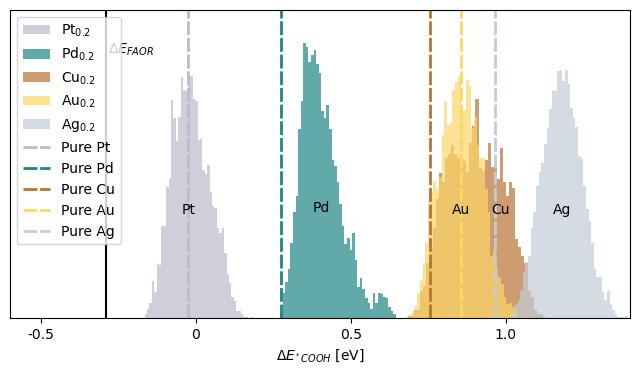

In [23]:
fig, ax = plt.subplots(figsize = (8, 4))

stochiometry = HEA_surface["stochiometry"]
for metal, numbers in reversed(separated_numbers.items()):
    ax.hist(numbers, label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", bins = 45, color = metal_colors[metal], alpha = 0.7, histtype='stepfilled')
    if metal == "Cu":
        ax.text(x = np.mean(numbers)+0.05, y = len(numbers)/45, s = metal)
    else:
        ax.text(x = np.mean(numbers)-0.03, y = len(numbers)/45, s = metal)

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 1.4)
ax.set_ylim(0, 525)

ax.set_xlabel("$\Delta E_{^*COOH}$ [eV]")

ax.axvline(x = -corrections["Jack_COOH"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["Jack_COOH"]+0.005, y = 450, s = "$\Delta E_{FAOR}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_COOH"])):
    plt.vlines(metal_energy, ymin=0, ymax=600, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+metal)

plt.legend()
plt.savefig("../figures/Binding_Energy_Predictions/COOH_E_HEA_EVEN.png", dpi = 400, bbox_inches = "tight")

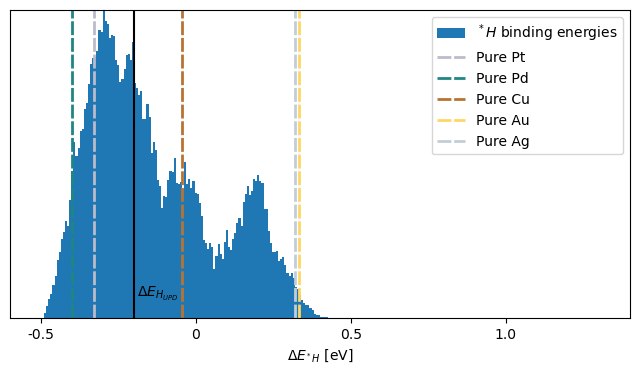

In [24]:
fig, ax = plt.subplots(figsize = (8, 4))

# Plot the data
plt.hist(HEA_surface["H_E"].flatten(), bins = 45*3+1, label = "$^*H$ binding energies")#, color = "#00aff0")

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 1.4)
ax.set_ylim(0, 720)

ax.set_xlabel("$\Delta E_{^*H}$ [eV]")

ax.axvline(x = -corrections["Jack_H"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["Jack_H"]+0.01, y = 50, s = "$\Delta E_{H_{UPD}}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_H"])):
    plt.vlines(metal_energy, ymin=0, ymax=755, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+metal)

ax.legend()

plt.savefig("../figures/Binding_Energy_Predictions/H_E_HEA_EVEN.png", dpi = 400, bbox_inches = "tight")

In [ ]:
# Could I make a different colour for each metal present?
# One histogram for all metals seperately present in the 3 closest?
# All energies will be present 3 times

# Could I use the roll thing and then look at same index?

# If I do it once, I will get one third of them

# It's just the same procedure as before, just three times where
# I roll the top atoms real quick

# Oh I should put the pure metal energies in there also.
# I could do the same for COOH


In [28]:
# Assuming HEA_surface["atoms"] is your 2D numpy array
label_matrix0 = HEA_surface["atoms"][:,:,0]
number_matrix = HEA_surface["H_E"]

# Roll the contents down by one position along axis 0
label_matrix1 = np.roll(label_matrix0, shift=1, axis=0) # Works

# Roll the contents to the left by one position along axis 1
label_matrix2 = np.roll(label_matrix0, shift=-1, axis=1) # Works

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix0)

# Initialize a dictionary to store separated numbers by label
separated_numbers = {label: [] for label in unique_labels}

for label_matrix in [label_matrix0, label_matrix1, label_matrix2]:

    # Iterate through labels and separate numbers
    for label in unique_labels:
        mask = (label_matrix == label)  # Create a boolean mask for the current label
        numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
        separated_numbers[label].extend(numbers_for_label) #Den her skal plusse oveni i stedet for at erstatte

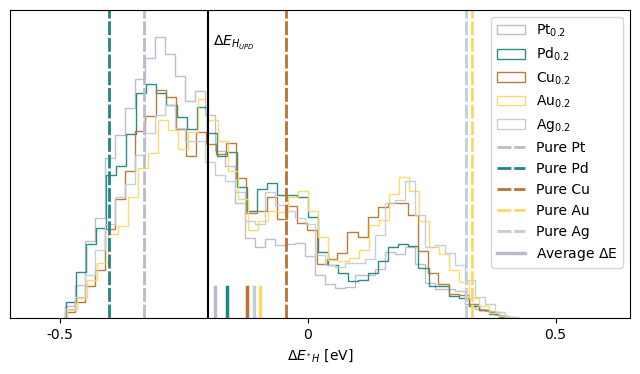

In [29]:
fig, ax = plt.subplots(figsize = (8, 4))

stochiometry = HEA_surface["stochiometry"]
# Plot the data
for metal, numbers in reversed(separated_numbers.items()):
    ax.hist(numbers, label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", bins = 45, color = metal_colors[metal], alpha = 0.95, histtype='step')

    #ax.text(x = np.mean(numbers), y = len(numbers)/45, s = metal)
    #ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linewidth = 2.5, color = metal_colors[metal])

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xticklabels([-0.5, 0, 0.5])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 0.65)
ax.set_ylim(0, 1700)

ax.set_xlabel("$\Delta E_{^*H}$ [eV]")

ax.axvline(x = -corrections["Jack_H"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["Jack_H"]+0.01, y = 1500, s = "$\Delta E_{H_{UPD}}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_H"])):
    plt.vlines(metal_energy, ymin=0, ymax=1780, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+ metal)
    #if metal == "Pt":
    #    plt.vlines(metal_energy, ymin=0, ymax=1480, colors=metal_colors[metal], linestyle='-', lw=2, label="Pure metal")
    #else:
    #    plt.vlines(metal_energy, ymin=0, ymax=1480, colors=metal_colors[metal], linestyle='-', lw=2)

for metal, numbers in reversed(separated_numbers.items()):
    if metal == "Pt":
        ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linestyle = "-", linewidth = 2.5, color = metal_colors[metal], label = "Average $\Delta$E")
    else:
        ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linestyle = "-", linewidth = 2.5, color = metal_colors[metal])

ax.legend()

plt.savefig("../figures/Binding_Energy_Predictions/H_E_HEA_EVEN_Details.png", dpi = 400, bbox_inches = "tight")

In [96]:
for metal, numbers in reversed(separated_numbers.items()):
    print("The average binding energy in a site where "+metal+" is present is: " + str(np.mean(numbers)))

The average binding energy in a site where Pt is present is: -0.18531996
The average binding energy in a site where Pd is present is: -0.16171914
The average binding energy in a site where Cu is present is: -0.118449405
The average binding energy in a site where Au is present is: -0.09527455
The average binding energy in a site where Ag is present is: -0.1055968


I want to load the pure metal energies automatic in functions.py

### Given energies compared to energies

In [51]:
HEA_surface.keys() #H_given_COOH_down etc. etc.


dict_keys(['atoms', 'stochiometry', 'ads_top', 'ads_hol', 'COOH_E', 'H_E', 'mixed_down', 'mixed_up_right', 'mixed_up_left', 'O_E', 'OH_E', 'H_V', 'O_V', 'COOH_V', 'OH_V', 'COOH_given_H_down', 'COOH_given_H_up_right', 'COOH_given_H_up_left', 'H_given_COOH_down', 'H_given_COOH_up_right', 'H_given_COOH_up_left'])

### **H**

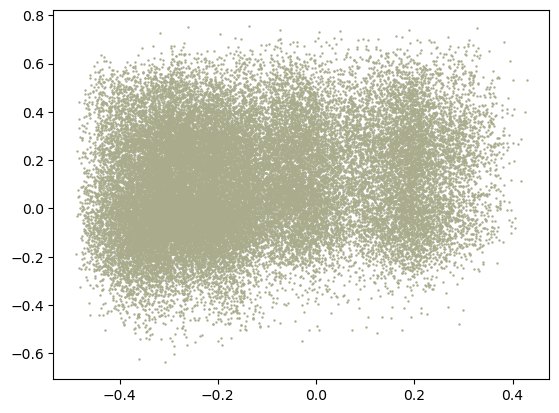

In [195]:
plt.scatter(HEA_surface["H_E"].flatten(), HEA_surface["H_given_COOH_up_right"].flatten(), s = 0.5, c = "#a9ab8c")

In [164]:
# Convert hexadecimal color codes to RGB tuples
rgb_colors = [tuple(int(color[i:i+2], 16) for i in (1, 3, 5)) for color in metal_colors.values()]

# Calculate the average RGB color
average_color = (
    int(np.mean([color[0] for color in rgb_colors])),
    int(np.mean([color[1] for color in rgb_colors])),
    int(np.mean([color[2] for color in rgb_colors]))
)

# Convert the average RGB color back to a hexadecimal color code
average_color_hex = '#{:02x}{:02x}{:02x}'.format(*average_color)

print(f"Average Color: {average_color_hex}")

Average Color: #a9ab8c


In [35]:
# Assuming HEA_surface["atoms"] is your 2D numpy array
label_matrix0 = HEA_surface["atoms"][:,:,0]
number_matrix = HEA_surface["H_E"]

# Roll the contents down by one position along axis 0
label_matrix1 = np.roll(label_matrix0, shift=1, axis=0) # Works

# Roll the contents to the left by one position along axis 1
label_matrix2 = np.roll(label_matrix0, shift=-1, axis=1) # Works

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix0)

# Initialize a dictionary to store separated numbers by label
separated_numbers_H = {label: [] for label in unique_labels}

for label_matrix in [label_matrix0, label_matrix1, label_matrix2]:

    # Iterate through labels and separate numbers
    for label in unique_labels:
        mask = (label_matrix == label)  # Create a boolean mask for the current label
        numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
        separated_numbers_H[label].extend(numbers_for_label) #Den her skal plusse oveni i stedet for at erstatte

In [36]:
# Assuming HEA_surface["atoms"] is your 2D numpy array
label_matrix0 = HEA_surface["atoms"][:,:,0]
number_matrix = HEA_surface["H_given_COOH_up_right"]

# Roll the contents down by one position along axis 0
label_matrix1 = np.roll(label_matrix0, shift=1, axis=0) # Works

# Roll the contents to the left by one position along axis 1
label_matrix2 = np.roll(label_matrix0, shift=-1, axis=1) # Works

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix0)

# Initialize a dictionary to store separated numbers by label
separated_numbers_H_given_COOH = {label: [] for label in unique_labels}

for label_matrix in [label_matrix0, label_matrix1, label_matrix2]:

    # Iterate through labels and separate numbers
    for label in unique_labels:
        mask = (label_matrix == label)  # Create a boolean mask for the current label
        numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
        separated_numbers_H_given_COOH[label].extend(numbers_for_label) #Den her skal plusse oveni i stedet for at erstatte

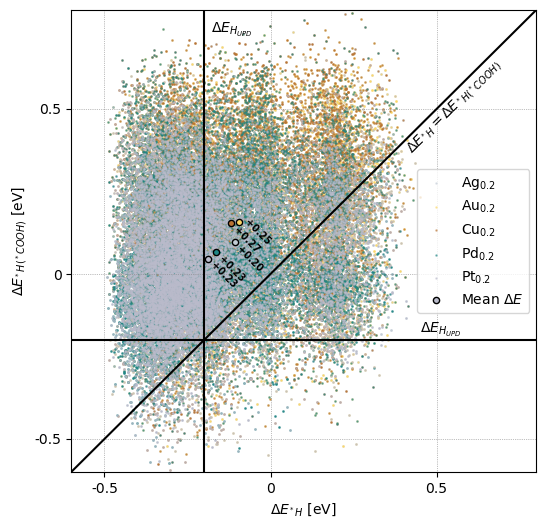

In [41]:
fig, ax = plt.subplots(figsize = (6, 6))

H_energies            = HEA_surface["H_E"].flatten()
H_given_COOH_energies = HEA_surface["H_given_COOH_up_right"].flatten()

#ax.scatter(H_energies, H_given_COOH_energies, label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", s = 0.8, alpha = 0.8, c = "#a9ab8c")

#########

for metal in metals:
    ax.scatter(separated_numbers_H[metal], separated_numbers_H_given_COOH[metal], label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", s = 0.7, alpha = 0.5, c = metal_colors[metal])
for metal in metals:
    if metal == "Pt":
        ax.scatter(np.mean(separated_numbers_H[metal]), np.mean(separated_numbers_H_given_COOH[metal]), s = 20, c = metal_colors[metal], edgecolors='black', label = "Mean $\Delta E$")
    else:
        ax.scatter(np.mean(separated_numbers_H[metal]), np.mean(separated_numbers_H_given_COOH[metal]), s = 20, c = metal_colors[metal], edgecolors='black')

# Add text that says how much higher the avg 
for metal in metals:
    diff = np.mean(separated_numbers_H_given_COOH[metal]) - np.mean(separated_numbers_H[metal])
    xmean = np.mean(separated_numbers_H[metal])
    ymean = np.mean(separated_numbers_H_given_COOH[metal])
    if metal == "Au":
        ax.text(x = xmean+0.01, y = ymean-0.07, s = f"+{diff:.2f}", fontsize = 7, rotation = 360-45, weight = "bold")
    else:
        ax.text(x = xmean-0.00, y = ymean-0.09, s = f"+{diff:.2f}", fontsize = 7, rotation = 360-45, weight = "bold")

##########

# Add text that says how much higher the avg 
#diff = np.mean(H_given_COOH_energies) - np.mean(H_energies)
#xmean = np.mean(H_energies)
#ymean = np.mean(H_given_COOH_energies)
#ax.text(x = xmean+0.01, y = ymean+0.02, s = f"+{diff:.2f}", fontsize = 7, rotation = 45)

# Set limits
xmin, xmax = -0.6, 0.8
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)

# Make diagonal line
ax.plot([xmin, xmax], [xmin, xmax], c = "black")
#ax.text(x = 1.25, y =  1.35, s = "$\Delta E_{^*COOH} = \Delta E_{^*COOH(^*H)}$", rotation = 45)
ax.text(x = 0.40, y =  0.37, s = "$\Delta E_{^*H} = \Delta E_{^*H(^*COOH)}$", rotation = 45)

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xticklabels([-0.5, 0, 0.5])
ax.set_yticks([-0.5, 0, 0.5])
ax.set_yticklabels([-0.5, 0, 0.5])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
ax.set_ylabel("$\Delta E_{^*H(^*COOH)}$ [eV]")

# Make lines at the correction constants
ax.axhline(y = -corrections["Jack_H"], xmin = xmin, xmax = xmax+0.3, c = "black")
ax.axvline(x = -corrections["Jack_H"], ymin = xmin, ymax = xmax+0.3, c = "black")

# And text for those correction lines
ax.text(x = -0.18, y =  0.73, s = "$\Delta E_{H_{UPD}}$")
ax.text(x =  0.45, y = -0.18, s = "$\Delta E_{H_{UPD}}$")

ax.legend(loc = "center right")
filename = "Binding_Energy_Predictions/H_given_COOH_change"
plt.savefig("../figures/"+filename+".png", dpi = 600, bbox_inches = "tight")

In [233]:
diff_list = []
for metal in metals:
    diff_list.append(np.mean(separated_numbers_H_given_COOH[metal]) - np.mean(separated_numbers_H[metal]))

np.mean(diff_list)

0.2388033

In [ ]:
# Oh, the data was actually right, I just didn't think about what it was supposed to look like

### **COOH**

In [42]:
number_matrix = HEA_surface["COOH_E"]
label_matrix  = HEA_surface["atoms"][:,:,0]

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix)

# Initialize a dictionary to store separated numbers by label
separated_numbers_COOH = {label: [] for label in unique_labels}

# Iterate through labels and separate numbers
for label in unique_labels:
    mask = (label_matrix == label)  # Create a boolean mask for the current label
    numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
    separated_numbers_COOH[label] = numbers_for_label

# separated_numbers will now contain arrays of numbers for each label

In [43]:
number_matrix = HEA_surface["COOH_given_H_down"]
label_matrix  = HEA_surface["atoms"][:,:,0]

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix)

# Initialize a dictionary to store separated numbers by label
separated_numbers_COOH_given_H = {label: [] for label in unique_labels}

# Iterate through labels and separate numbers
for label in unique_labels:
    mask = (label_matrix == label)  # Create a boolean mask for the current label
    numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
    separated_numbers_COOH_given_H[label] = numbers_for_label

# separated_numbers will now contain arrays of numbers for each label

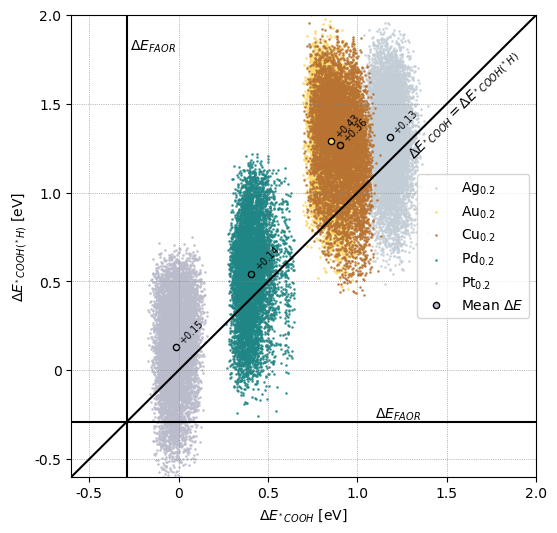

In [47]:
fig, ax = plt.subplots(figsize = (6, 6))

for metal in metals:
    ax.scatter(separated_numbers_COOH[metal], separated_numbers_COOH_given_H[metal], label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", s = 0.8, alpha = 0.8, c = metal_colors[metal])
for metal in metals:
    if metal == "Pt":
        ax.scatter(np.mean(separated_numbers_COOH[metal]), np.mean(separated_numbers_COOH_given_H[metal]), s = 20, c = metal_colors[metal], edgecolors='black', label = "Mean $\Delta E$")
    else:
        ax.scatter(np.mean(separated_numbers_COOH[metal]), np.mean(separated_numbers_COOH_given_H[metal]), s = 20, c = metal_colors[metal], edgecolors='black')

# Add text that says how much higher the avg 
for metal in metals:
    diff = np.mean(separated_numbers_COOH_given_H[metal]) - np.mean(separated_numbers_COOH[metal])
    xmean = np.mean(separated_numbers_COOH[metal])
    ymean = np.mean(separated_numbers_COOH_given_H[metal])
    ax.text(x = xmean+0.01, y = ymean+0.02, s = f"+{diff:.2f}", fontsize = 7, rotation = 45)

# Set limits
xmin, xmax = -0.6, 2.0
ax.set_xlim(-0.6, 2.0)
ax.set_ylim(-0.6, 2.0)

# Make diagonal line
ax.plot([xmin, xmax], [xmin, xmax], c = "black")
#ax.text(x = 1.25, y =  1.35, s = "$\Delta E_{^*COOH} = \Delta E_{^*COOH(^*H)}$", rotation = 45)
ax.text(x = 1.27, y =  1.20, s = "$\Delta E_{^*COOH} = \Delta E_{^*COOH(^*H)}$", rotation = 45)

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0, 1.5, 2.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([-0.5, 0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticklabels([-0.5, 0, 0.5, 1.0, 1.5, 2.0])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_xlabel("$\Delta E_{^*COOH}$ [eV]")
ax.set_ylabel("$\Delta E_{^*COOH(^*H)}$ [eV]")

# Make lines at the correction constants
ax.axhline(y = -corrections["Jack_COOH"], xmin = xmin, xmax = xmax, c = "black")
ax.axvline(x = -corrections["Jack_COOH"], ymin = xmin, ymax = xmax, c = "black")

# And text for those correction lines
ax.text(x = -corrections["Jack_COOH"]+0.02, y =  1.8, s = "$\Delta E_{FAOR}$")
ax.text(x =  1.1, y = -corrections["Jack_COOH"]+0.02, s = "$\Delta E_{FAOR}$")

ax.legend(loc = "center right")
filename = "Binding_Energy_Predictions/COOH_given_H_change"
plt.savefig("../figures/"+filename+".png", dpi = 600, bbox_inches = "tight")

In [ ]:
# Wait, if these points stem from the SAME types of sites,
# shouldn't the energies be way more similar?
# How can there be like 1 eV of difference for some sites?
# Is it just because of the site type actually doing that,
# or the model sucking?

In [235]:
diff_list = []
for metal in metals:
    diff = np.mean(separated_numbers_COOH_given_H[metal]) - np.mean(separated_numbers_COOH[metal])
    diff_list.append(diff)
    print(f"The difference between COOH given H and just COOH for {metal} is: + {diff:.2f}")
print(f"The difference across all metals is: {np.mean(diff_list)}")
for metal in metals:
    variance_given = np.std(separated_numbers_COOH_given_H[metal])
    variance_pure  = np.std(separated_numbers_COOH[metal])
    print(f"The standard deviation on the COOH given H energies for {metal} is: {variance_given:.2f}")
    print(f"The standard deviation on the COOH energies for {metal} is: {variance_pure:.2f}")

The difference between COOH given H and just COOH for Ag is: + 0.14
The difference between COOH given H and just COOH for Au is: + 0.44
The difference between COOH given H and just COOH for Cu is: + 0.37
The difference between COOH given H and just COOH for Pd is: + 0.14
The difference between COOH given H and just COOH for Pt is: + 0.14
The difference across all metals is: 0.24372681975364685
The standard deviation on the COOH given H energies for Ag is: 0.25
The standard deviation on the COOH energies for Ag is: 0.06
The standard deviation on the COOH given H energies for Au is: 0.26
The standard deviation on the COOH energies for Au is: 0.06
The standard deviation on the COOH given H energies for Cu is: 0.27
The standard deviation on the COOH energies for Cu is: 0.08
The standard deviation on the COOH given H energies for Pd is: 0.26
The standard deviation on the COOH energies for Pd is: 0.07
The standard deviation on the COOH given H energies for Pt is: 0.25
The standard deviation 

#### Looking at the standard deviation of the energies in the training data

In [153]:
df_HEA = pd.read_csv("../csv_features/DeltaE/mixed_HEA_COOH.csv")
df_SWR = pd.read_csv("../csv_features/DeltaE/mixed_SWR_COOH.csv")
all_DFT_Es = df_HEA["G_ads (eV)"].to_list() + df_SWR["G_ads (eV)"].to_list()
np.std(all_DFT_Es)

0.42496671154700016

In [155]:
print(f'HEA: {np.std(df_HEA["G_ads (eV)"].to_list())}')
print(f'SWR: {np.std(df_SWR["G_ads (eV)"].to_list())}')
print(f'Combined: {np.std(all_DFT_Es)}')

HEA: 0.55880901445372
SWR: 0.26377759725757594
Combined: 0.42496671154700016


In [160]:
# H
df_H = pd.read_csv("../csv_features/DeltaE/H_DFT_features.csv")
np.std(df_H["G_ads (eV)"].to_list())

0.23185649086453702

In [161]:
np.sqrt(0.4249**2+0.2318**2)

0.48401575387584234

In [158]:
# How about in the predictions on the HEA surface?
np.std(HEA_surface["COOH_given_H_down"].flatten())

0.55359036

In [162]:
# I guess the uncertainties are actually the ones from the parity plots
np.sqrt(0.056**2+0.069**2)

0.08886506625215558

In [ ]:
# Are the means in the DFT data also different? If the exact same slabs exist, one could math them. Not sure there is identical slabs between COOH + H mixed sites and H slabs

In [ ]:
# I guess I could do a manual calculation from the DFT data
# (Mixed DFT slab - slab) + (H slab - slab) # I do have single-element energies

# I could also just show the mean to show if the model thinks its more sucky with H on the side

In [65]:
HEA_surface.keys()

dict_keys(['atoms', 'stochiometry', 'ads_top', 'ads_hol', 'COOH_E', 'H_E', 'mixed_down', 'mixed_up_right', 'mixed_up_left', 'O_E', 'OH_E', 'H_V', 'O_V', 'COOH_V', 'OH_V', 'COOH_given_H_down', 'COOH_given_H_up_right', 'COOH_given_H_up_left', 'H_given_COOH_down', 'H_given_COOH_up_right', 'H_given_COOH_up_left'])